In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [10]:
def load_year_data(year, file_type):
    # file_type should be 'A1' or 'A2'
    path = f"dataset/{file_type}/{year}_{file_type}_cleaned.csv"
    df = pd.read_csv(path)
    # Assign labels: 1 for A1 (fatal), 0 for A2 (injury)
    df["label"] = 1 if file_type == "A1" else 0
    return df

In [11]:
train_years = ["108", "109", "110", "111", "112"]

train_dfs_A1 = [load_year_data(year, "A1") for year in train_years]
train_dfs_A2 = [load_year_data(year, "A2") for year in train_years]

df_train = pd.concat(train_dfs_A1 + train_dfs_A2, ignore_index=True)

df_a1_test = load_year_data("113", "A1")
df_a2_test = load_year_data("113", "A2")

df_a1_test["label"] = 1
df_a2_test["label"] = 0

# Combine into one DataFrame for testing
df_test = pd.concat([df_a1_test, df_a2_test], ignore_index=True)

In [12]:
categorical_cols = [
    "weather",
    "lighting",
    "road_condition",
    "traffic_signal",
    "vehicle_type",
    "gender",
    "protective_equipment"
]
numeric_cols = ["speed_limit", "age"]

# Drop rows with missing critical features in both training and testing sets
df_train.dropna(subset=categorical_cols + numeric_cols + ["label"], inplace=True)
df_test.dropna(subset=categorical_cols + numeric_cols + ["label"], inplace=True)

# Since the categorical columns are already numeric (0~n), we do not need to convert them.
# If needed, you can cast them to the proper dtype:
df_train[categorical_cols] = df_train[categorical_cols].astype(int)
df_test[categorical_cols] = df_test[categorical_cols].astype(int)

# Define features X and target y for training and testing
X_train = df_train[categorical_cols + numeric_cols]
y_train = df_train["label"]

X_test = df_test[categorical_cols + numeric_cols]
y_test = df_test["label"]

In [13]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Print original class distribution
print("Original distribution:", Counter(y_train))

# Initialize SMOTE and oversample the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the new class distribution
print("Resampled distribution:", Counter(y_train))


Original distribution: Counter({0: 810425, 1: 5139})
Resampled distribution: Counter({1: 810425, 0: 810425})


In [14]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert probabilities to binary predictions
        y_pred = tf.cast(tf.greater(y_pred, self.threshold), tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [15]:
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, weights))
print("Class Weights:", class_weights)

# ------------------------------------------------
# 5) Build a TensorFlow (Keras) Model
# ------------------------------------------------
model = tf.keras.Sequential([
    layers.Dense(16, activation="relu", input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Second hidden layer with 64 units
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third hidden layer with 32 units
    layers.Dense(32, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Fourth hidden layer with 16 units
    layers.Dense(16, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Output layer for binary classification
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        F1Score(name='f1_score'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# ------------------------------------------------
# 6) Train Model with Class Weights using all 108 data for training
# ------------------------------------------------
history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=2048,
    validation_split=0.3,
    class_weight=class_weights,
    verbose=1
)

# ------------------------------------------------
# 7) Evaluate on Test Data from 109 files
# ------------------------------------------------
pred_probs = model.predict(X_test).ravel()
pred_labels = (pred_probs > 0.5).astype(int)

precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print("Precision:", precision)
print("Recall:   ", recall)
print("F1 Score: ", f1)

# Optional: detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, pred_labels, target_names=["A2 (Injury)", "A1 (Fatal)"]))


Class Weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}


/home/luluboy/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6544 - auc: 0.6495 - f1_score: 0.4096 - loss: 0.6450 - precision: 0.4146 - recall: 0.4214 - val_accuracy: 0.3013 - val_auc: 0.0000e+00 - val_f1_score: 0.4631 - val_loss: 0.9998 - val_precision: 1.0000 - val_recall: 0.3013
Epoch 2/80
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7391 - auc: 0.7499 - f1_score: 0.3705 - loss: 0.5174 - precision: 0.5951 - recall: 0.2690 - val_accuracy: 0.3364 - val_auc: 0.0000e+00 - val_f1_score: 0.5035 - val_loss: 0.9811 - val_precision: 1.0000 - val_recall: 0.3364
Epoch 3/80
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7469 - auc: 0.7656 - f1_score: 0.4208 - loss: 0.5054 - precision: 0.6094 - recall: 0.3214 - val_accuracy: 0.3701 - val_auc: 0.0000e+00 - val_f1_score: 0.5402 - val_loss: 0.9720 - val_precision: 1.0000 - val_recall: 0.3701
Epoch 4/80
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7561 - auc: 0.7757 - f1_score: 0.4468 - loss: 0.4965 - precision: 0.63

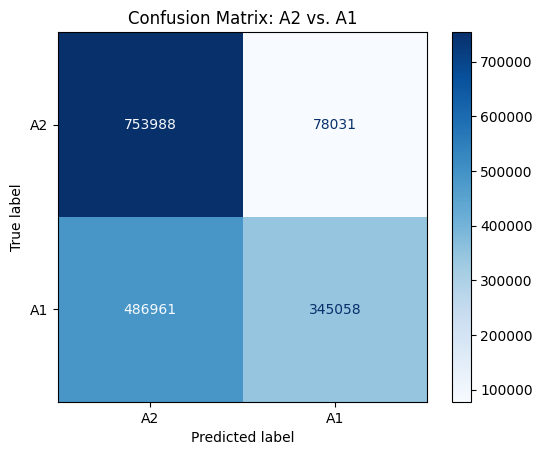

In [16]:
# 1. Compute the confusion matrix
cm = confusion_matrix(y_test, pred_labels)

# 2. Create a display object, optionally passing in class names
#    Here we assume label=0 -> A2, label=1 -> A1
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["A2", "A1"])

# 3. Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: A2 vs. A1")
plt.show()